In [53]:
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck18 as cosmo, z_at_value
from astroquery.vizier import Vizier
from scipy.interpolate import CubicSpline

In [ ]:
def poggianti1997_time(z):
    q0 = 0.225
    H0 = 50 * u.km / u.s / u.Mpc
    sqrt_one_2q0 = np.sqrt(1 - 2 * q0)
    sqrt_frac = np.sqrt(1 + 2 * q0 * z) / sqrt_one_2q0
    t = (-4 * q0 / (H0 * sqrt_one_2q0**3)
        * (
            0.5 * sqrt_frac / (1 - sqrt_frac**2)
            + 0.25 * np.log(np.abs((1 + sqrt_frac) / (1 - sqrt_frac)))
         )
    )
    return t


def poggianti1997_lookback_time(z):
    return poggianti1997_time(0) - poggianti1997_time(z)


def lookback_time_to_redshift(t):
    return z_at_value(cosmo.lookback_time, t)

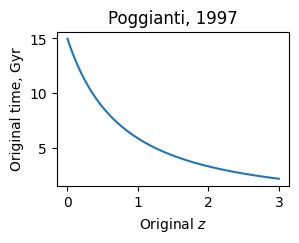

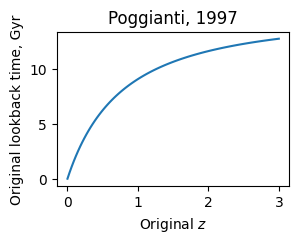

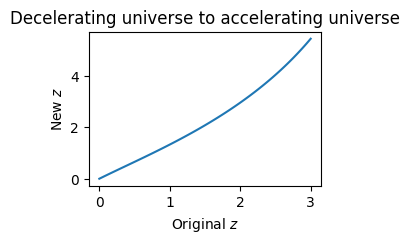

In [10]:
# we add this small number because z_at_value doesn't like small redshifts
z_ = np.linspace(0, 3, 101) + 1e-6
z = lookback_time_to_redshift(poggianti1997_lookback_time(z_))


plt.figure(figsize=(3, 2))
plt.title('Poggianti, 1997')
plt.xlabel('Original $z$')
plt.ylabel('Original time, Gyr')
plt.plot(z_, poggianti1997_time(z_).to(u.Gyr))

plt.figure(figsize=(3, 2))
plt.title('Poggianti, 1997')
plt.xlabel('Original $z$')
plt.ylabel('Original lookback time, Gyr')
plt.plot(z_, poggianti1997_lookback_time(z_).to(u.Gyr))

plt.figure(figsize=(3, 2))
plt.title('Decelerating universe to accelerating universe')
plt.xlabel('Original $z$')
plt.ylabel('New $z$')
plt.plot(z_, z)

In [40]:
ecorr_table, = Vizier(row_limit=1000).get_catalogs('J/A+AS/122/399/ecorr')
kcorr_table, = Vizier(row_limit=1000).get_catalogs('J/A+AS/122/399/kcorr')
np.testing.assert_array_equal(np.unique(ecorr_table['Filt']), np.unique(kcorr_table['Filt']))

AssertionError: 
Arrays are not equal

(shapes (16,), (13,) mismatch)
 x: MaskedColumn(['B', 'Bj', 'H', 'I', 'Ic', 'In', 'J', 'K', 'R', 'Rc', 'Rf',
              'U', 'V', 'g', 'i', 'r'], dtype='<U2')
 y: MaskedColumn(['B', 'H', 'I', 'Ic', 'J', 'K', 'R', 'Rc', 'U', 'V', 'g',
              'i', 'r'], dtype='<U2')

In [56]:
def make_kcorr_spline(band, galtype):
    mask = kcorr_table['Filt'] == band
    z = kcorr_table['z'][mask]
    kcorr = kcorr_table[galtype][mask]
    return CubicSpline(z, kcorr, bc_type='natural', extrapolate=False)


def make_ecorr_spline(band, galtype, original_z=False):
    mask = ecorr_table['Filt'] == band
    z = ecorr_table['z'][mask]
    if not original_z:
        z = lookback_time_to_redshift(poggianti1997_lookback_time(z))
    ecorr = ecorr_table[galtype][mask]
    return CubicSpline(z, ecorr, bc_type='natural', extrapolate=False)

Text(0, 0.5, 'K+E')

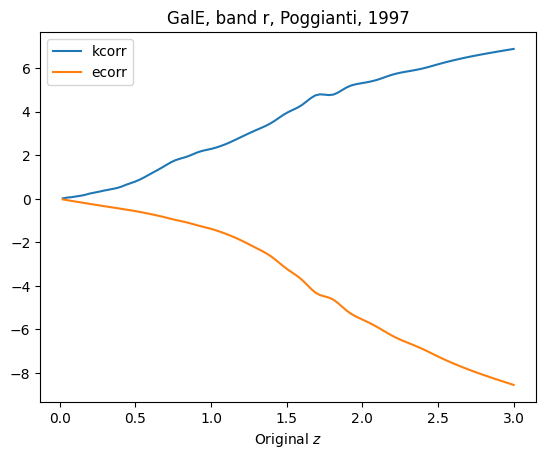

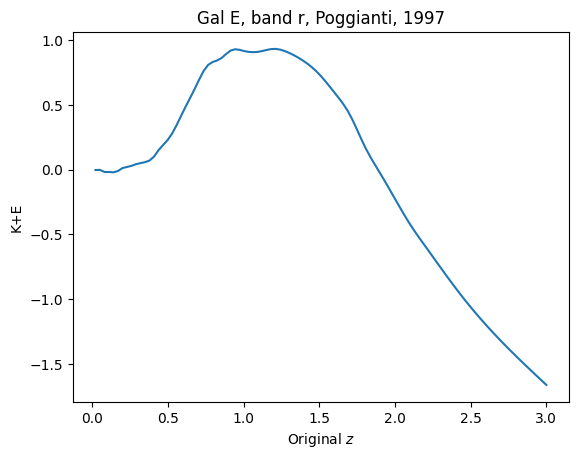

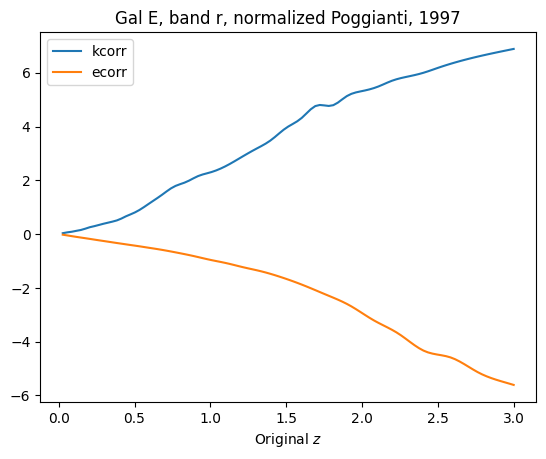

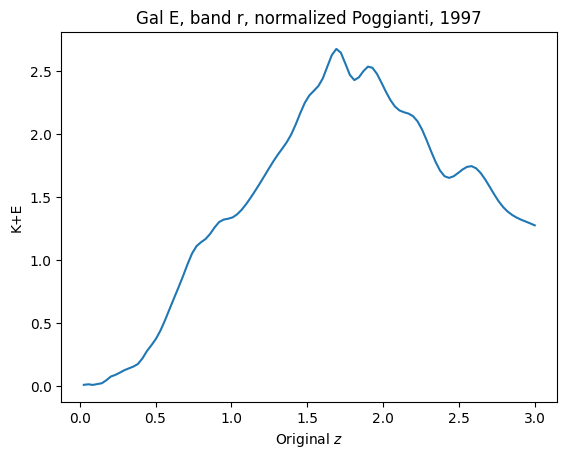

In [63]:
GALTYPE = 'E'
BAND = 'r'

kcorr_spline = make_kcorr_spline(BAND, GALTYPE)
orig_ecorr_spline = make_ecorr_spline(BAND, GALTYPE, original_z=True)
ecorr_spline = make_ecorr_spline(BAND, GALTYPE, original_z=False)

orig_z_ = np.linspace(max(kcorr_spline.x.min(), orig_ecorr_spline.x.min()), min(kcorr_spline.x.max(), orig_ecorr_spline.x.max()), 101)
new_z_ = np.linspace(max(kcorr_spline.x.min(), ecorr_spline.x.min()), min(kcorr_spline.x.max(), ecorr_spline.x.max()), 101)

plt.figure()
plt.title(f'Gal{GALTYPE}, band {BAND}, Poggianti, 1997')
plt.plot(orig_z_, kcorr_spline(orig_z_), label='kcorr')
plt.plot(orig_z_, orig_ecorr_spline(orig_z_), label='ecorr')
plt.xlabel('Original $z$')
plt.legend()

plt.figure()
plt.title(f'Gal {GALTYPE}, band {BAND}, Poggianti, 1997')
plt.plot(orig_z_, kcorr_spline(orig_z_) + orig_ecorr_spline(orig_z_))
plt.xlabel('Original $z$')
plt.ylabel('K+E')

plt.figure()
plt.title(f'Gal {GALTYPE}, band {BAND}, normalized Poggianti, 1997')
plt.plot(new_z_, kcorr_spline(new_z_), label='kcorr')
plt.plot(new_z_, ecorr_spline(new_z_), label='ecorr')
plt.xlabel('Original $z$')
plt.legend()

plt.figure()
plt.title(f'Gal {GALTYPE}, band {BAND}, normalized Poggianti, 1997')
plt.plot(new_z_, kcorr_spline(new_z_) + ecorr_spline(new_z_))
plt.xlabel('Original $z$')
plt.ylabel('K+E')